# Teoria da Decisão - ELE088

*Prof. Lucas S. Batista*  
*Departamento de Engenharia Elétrica*  
*Universidade Federal de Minas Gerais*


*Trabalho Computacional 1 - WLAN*

*Henrique Perim e Vinicius Cardoso*

# Estudo de Caso

## Problema de Designação Generalizada:

- Considere que existam $n$ clientes e $m$ PAs ($n > m$), de tal forma que cada cliente deve ser atribuída a um único PA. A distância entre o cliente $j$ e o PA $i$ é $d_{ij}$ e $x_{ij}$ é 1 se o cliente $j$ for atendido pelo PA $i$ e 0 caso contrário. Formule um problema que atribua as os clientes de forma a minimizar a soma total das distâncias euclidianas entre os PAs ativos e os clientes sem exceder o número de PAs disponíveis.

## Modelagem do problema

**variáveis:**
$$ x_{ij}, y_i $$

**parâmetros:** \\

$n$: nr de clientes \\
$m$: nr de possíveis locais para o PA \\
$c_j$: consumo do cliente $j$ \\
$q_i$: capacidade do PA $i$ \\
$r_i$: raio de cobertura do PA $i$ \\
$\eta$: taxa de cobertura dos clientes \\
$d_{ij}$: distância entre o PA $i$ e o cliente $j$ \\
$m_{max}$: quantidade de PAs disponíveis

\\

Com o intúito de minimizar o custo total de execução de todas as tarefas, pode-se escrever a seguinte função objetivo:

$$ \min f_{2} = \sum_{i=1}^{m} \sum_{j=1}^{n} d_{ij} x_{ij} $$

Adicionalmente, este problema apresenta o seguinte conjunto de restrições:

\begin{align}
\sum_{i=1}^{m} \sum_{j=1}^{n} x_{ij} \geq n \eta \hspace{2cm} (R1) \\
\sum_{j=1}^{n} c_{j} x_{ij} \leq y_i q_i, \forall i \in \{1, \ldots, m\} \hspace{2cm} (R2) \\
d_{ij} x_{ij} \leq y_i r_i, \forall i \in \{1, \ldots, m\}, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R3) \\
\sum_{i=1}^{m} x_{ij} \leq 1, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R4) \\
\sum_{i=1}^{m} y_i \leq m_{max} \hspace{2cm} (R5) \\
x_{ij} \in \{0, 1\}, \forall i \in \{1, \ldots, m\}, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R6) \\
y_i \in \{0, 1\}, \forall i \in \{1, \ldots, m\} \hspace{2cm} (R7)
\end{align}

em que: \\
**R1** garante que o percentual mínimo de clientes seja atendido; \\
**R2** garante que a capacidade dos PAs ativos não seja violada; \\
**R3** garante que PAs ativos só atendam clientes que estejam dentro do seu raio de cobertura; \\
**R4** garante que cada cliente $j$ seja atribuído a no máximo um PA; \\
**R5** garante que o número máximo de PAs ativos não seja violado; \\
**R6** e **R7** definem o domínio das variáveis de otimização do problema.

## Otimização de uma instância arbitrária do problema via RVNS

A seguir são apresentados os trechos de código da implementação do RVNS para o estudo de caso apresentado.

In [ ]:
'''
Importa os módulos usados
'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

'''
Define um tipo de dado similar ao Pascal "record" or C "struct"
'''
class Struct:
    pass

Os dados da instância teste são definidos a seguir. Considera-se um número de $m = 25$ PAs e $n = 256$ clientes. Além disso, assume-se uma matriz de distâncias e uma matriz de recursos em que os custos/recursos de execução das tarefas $t_1, t_2, \ldots, t_j, \ldots, t_n$ pelo $i$-ésimo agente são apresentados ao longo da $i$-ésima linha. A disponibilidade de recursos do $i$-ésimo agente é acessada em $b_i$.

In [ ]:
'''
Define os dados de uma instância arbitrária do problema
'''

# Define os dados do problema com base nos dados do arquivo CSV
def probdef(m=25, n=256, csv_file='clientes.csv'):
    # m: Número máximo de PAs
    # n: Número de clientes

    eta = 0.95  # Taxa de cobertura dos clientes
    raio_cobertura = 70  # Raio de cobertura dos PAs em metros
    capacidade_pa = 54  # Capacidade de cada PA em Mbps

    # Carregue os dados do arquivo CSV
    df = pd.read_csv(csv_file, header=None)

    # Use os dados do CSV para calcular as distâncias e o consumo dos clientes
    distancia = np.zeros((m, n))
    consumo_clientes = np.zeros(n)

    for i in range(m):
        for j in range(n):
            x_diff = df.iloc[j, 0]  # coordenada x do cliente j (coluna 0)
            y_diff = df.iloc[j, 1]  # coordenada y do cliente j (coluna 1)
            consumo = df.iloc[j, 2]  # consumo do cliente j (coluna 2)

            distancia[i][j] = np.sqrt(x_diff**2 + y_diff**2)  # distância euclidiana
            consumo_clientes[j] = consumo

    # Capacidade total de cada PA para atender clientes dentro de seu raio de cobertura
    capacidade_total_pa = eta * capacidade_pa

    probdata = Struct()
    probdata.m = m
    probdata.n = n
    probdata.distancia = distancia
    probdata.capacidade_pa = capacidade_pa
    probdata.raio_cobertura = raio_cobertura
    probdata.consumo_clientes = consumo_clientes
    probdata.eta = eta
    probdata.capacidade_total_pa = capacidade_total_pa

    return probdata

Uma solução candidata $x$ para o problema foi modelada computacionalmente como uma lista de tarefas atribuídas, respectivamente, aos agentes $a_1, a_2, ... a_i, ..., a_n$.

In [ ]:
import numpy as np

def sol_inicial(probdata):
    # Inicializa a solução
    x = Struct()
    x.solution = [[] for _ in range(probdata.m)]  # Cria uma lista de listas vazias para representar a solução

    # Gere uma lista de clientes
    list_of_clients = np.arange(probdata.n)

    # Ordene os clientes pela distância ao PA mais próximo
    list_of_clients = sorted(list_of_clients, key=lambda c: min(probdata.distancia[:, c]))

    for cliente in list_of_clients:
        # Verifique a capacidade disponível de cada PA dentro do raio de cobertura
        capacidade_disponivel = [probdata.capacidade_pa for _ in range(probdata.m)]
        for pa in range(probdata.m):
            for cliente_alocado in x.solution[pa]:
                if probdata.distancia[pa][cliente_alocado] > probdata.raio_cobertura:
                    continue  # Cliente está fora do raio de cobertura deste PA
                capacidade_disponivel[pa] -= probdata.consumo_clientes[cliente_alocado]

        # Encontre o PA mais próximo com capacidade disponível
        pa_index = np.argmin([probdata.distancia[pa][cliente] if capacidade_disponivel[pa] >= probdata.consumo_clientes[cliente] else np.inf for pa, cliente in enumerate(range(probdata.m))])

        # Aloque o cliente ao PA mais próximo
        x.solution[pa_index].append(cliente)

    return x

A função objetivo é implementada conforme a definição apresentada anteriormente. De forma geral, dada uma solução $x$, que indica a distribuição de clientes a PAs, esta função computa o somatório das distâncias euclidianas entre os PAs e os clientes.

In [ ]:
'''
Implementa a função objetivo do problema
'''
def fobj(x, probdata):

    '''
                a1            a2     ...     am
    x = [ [t7 t3 ... t9] [t4 ... t2] ... [t5 ... t8] ]
    '''

    fit = [] # armazena o custo de cada agente i
    g   = [] # armazena o valor da restrição R2 para cada agente i
    for i in np.arange(0,probdata.m,1):
        fit_i = 0.0
        recurso_i = 0.0
        for j in np.arange(0,len(x.solution[i]),1):
            fit_i += probdata.custo[i,x.solution[i][j]]       # somatório dos custos do i-ésimo agente
            recurso_i += probdata.recurso[i,x.solution[i][j]] # somatório dos recursos consumidos pelo i-ésimo agente

        fit.append(fit_i)
        g.append(recurso_i - probdata.b[i])

    fit = np.array(fit)
    g   = np.array(g)

    x.fitness = fit.sum()                                 # custo total da solução candidata x
    x.penalidade = 100*np.sum(np.where(g <= 0, 0, g)**2)  # penalidade aplicada sobre a solução x
    x.fitness_penalizado = x.fitness + x.penalidade       # custo total penalizado da solução x

    return x

A função *neighborhoodChange* atualiza a solução corrente e também a estrutura de vizinhança. De forma geral, se a nova solução gerada $y$ apresentar um custo *fitness_y* menor que o da solução incumbente $x$, então a solução incumbente é atualizada e retoma-se a primeira estrutura de vizinhança, i.e., faz-se $k = 1$. Caso contrário, apenas segue-se para a próxima estrutura de vizinhança, mantendo-se a solução corrente $x$.

In [ ]:
'''
Implementa a função neighborhoodChange
'''
def neighborhoodChange(x, y, k):

    if y.fitness_penalizado < x.fitness_penalizado:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1

    return x, k

Para o estudo de caso em questão foram propostas três estruturas de vizinhanças:

1. A primeira estrutura de vizinhança realiza a troca de duas tarefas entre agentes (aleatoriamente).
2. A segunda estrutura de vizinhança remove uma tarefa de um agente e a aloca em outro (aleatoriamente).
3. A terceira estrutura de vizinhança desloca uma tarefa de um 1o agente para um 2o, e deste 2o agente para um 3o (aleatoriamente).

In [ ]:
'''
Implementa a função shake
'''
def shake(x, k, probdata):

    y = copy.deepcopy(x)
    random_agent = np.random.permutation(probdata.m)

    if k == 1: # troca duas tarefas entre agentes (aleatoriamente)
        random_job_idx0 = np.random.randint(len(y.solution[random_agent[0]]))
        random_job0 = y.solution[random_agent[0]].pop(random_job_idx0)

        random_job_idx1 = np.random.randint(len(y.solution[random_agent[1]]))
        random_job1 = y.solution[random_agent[1]].pop(random_job_idx1)

        y.solution[random_agent[0]].append(random_job1)
        y.solution[random_agent[1]].append(random_job0)

    elif k == 2: # remove uma tarefa de um agente e a aloca em outro (aleatoriamente)
        random_job_idx = np.random.randint(len(y.solution[random_agent[0]]))
        random_job = y.solution[random_agent[0]].pop(random_job_idx)
        y.solution[random_agent[1]].append(random_job)

    elif k == 3: # desloca uma tarefa de um 1o agente para um 2o, e deste 2o agente para um 3o (aleatoriamente)
        random_job_idx0 = np.random.randint(len(y.solution[random_agent[0]]))
        random_job0 = y.solution[random_agent[0]].pop(random_job_idx0)

        random_job_idx1 = np.random.randint(len(y.solution[random_agent[1]]))
        random_job1 = y.solution[random_agent[1]].pop(random_job_idx1)

        y.solution[random_agent[2]].append(random_job1)
        y.solution[random_agent[1]].append(random_job0)

    return y

### Estrutura principal do método RVNS


--- SOLUÇÃO INICIAL CONSTRUÍDA ---

Sequência de tarefas atribuídas aos agentes:

x = [[21, 18, 22, 0, 6, 15], [20, 17, 23, 7, 16], [24, 4], [14, 2, 13, 3, 9], [5, 12, 19, 10, 11, 1, 8]]

fitness(x) = 737.00

fitness(x) penalizado = 8837.00

penalidade(x) = 8100.00


--- MELHOR SOLUÇÃO ENCONTRADA ---

Sequência de tarefas atribuídas aos agentes:

x = [[22, 23, 8, 14, 1], [18, 24, 7, 13], [12, 9, 15, 10, 0, 21], [2, 6, 20, 11, 3], [19, 16, 4, 5, 17]]

fitness(x) = 419.00

fitness(x) penalizado = 419.00

penalidade(x) = 0.00



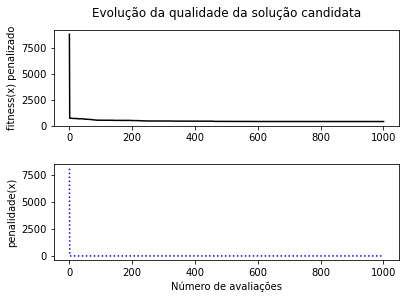

In [ ]:
'''
Implementa uma metaheurística RVNS
'''

# Contador do número de soluções candidatas avaliadas
num_sol_avaliadas = 0

# Máximo número de soluções candidatas avaliadas
max_num_sol_avaliadas = 1000

# Número de estruturas de vizinhanças definidas
kmax = 3

# Faz a leitura dos dados da instância do problema
probdata = probdef(m=5,n=25)

# Gera solução inicial
x = sol_inicial(probdata)

# Avalia solução inicial gerada
x = fobj(x,probdata)
num_sol_avaliadas += 1

# Armazena dados para plot
historico = Struct()
historico.fit = []
historico.sol = []
historico.pen = []
historico.fit_pen = []
historico.fit.append(x.fitness)
historico.sol.append(x.solution)
historico.pen.append(x.penalidade)
historico.fit_pen.append(x.fitness_penalizado)


# Ciclo iterativo do método
while num_sol_avaliadas < max_num_sol_avaliadas:

    k = 1
    while k <= kmax:

        # Gera uma solução candidata na k-ésima vizinhança de x
        y = shake(x,k,probdata)
        y = fobj(y,probdata)
        num_sol_avaliadas += 1

        # Atualiza solução corrente e estrutura de vizinhança (se necessário)
        x, k = neighborhoodChange(x, y, k)

        # Armazena dados para plot
        historico.fit.append(x.fitness)
        historico.sol.append(x.solution)
        historico.pen.append(x.penalidade)
        historico.fit_pen.append(x.fitness_penalizado)


print('\n--- SOLUÇÃO INICIAL CONSTRUÍDA ---\n')
print('Sequência de tarefas atribuídas aos agentes:\n')
print('x = {}\n'.format(historico.sol[0]))
print('fitness(x) = {:.2f}\n'.format(historico.fit[0]))
print('fitness(x) penalizado = {:.2f}\n'.format(historico.fit_pen[0]))
print('penalidade(x) = {:.2f}\n'.format(historico.pen[0]))

print('\n--- MELHOR SOLUÇÃO ENCONTRADA ---\n')
print('Sequência de tarefas atribuídas aos agentes:\n')
print('x = {}\n'.format(x.solution))
print('fitness(x) = {:.2f}\n'.format(x.fitness))
print('fitness(x) penalizado = {:.2f}\n'.format(x.fitness_penalizado))
print('penalidade(x) = {:.2f}\n'.format(x.penalidade))

fig, (ax1, ax2) = plt.subplots(2, 1)
s = len(historico.fit_pen)
ax1.plot(np.linspace(0,s-1,s),historico.fit_pen,'k-')
ax2.plot(np.linspace(0,s-1,s),historico.pen,'b:')
fig.suptitle('Evolução da qualidade da solução candidata')
ax1.set_ylabel('fitness(x) penalizado')
ax2.set_ylabel('penalidade(x)')
ax2.set_xlabel('Número de avaliações')
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()